## 6.6. Sourcing & Analyzing Time Series Data - Real Retail and Food Services Sales

### This script contains the following:

#### 1. Importing your libraries and data
#### 2. Subsetting, wrangling, and cleaning time-series data
#### 3. Time series analysis: decomposition
#### 4. Testing for stationarity
#### 5. Stationarizing the Federal Reserve Economic Data

### 1. Importing your libraries and data

Before you start this analysis, you'll need a new library you haven't installed before—Quandl. Install Quandl using conda:

`conda install quandl`

In [2]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear. More examples here:
# https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
# https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html

In [3]:
# Configure API key 

quandl.ApiConfig.api_key = 'Mor7H11Vih3mNguHwke_'

In [4]:
# Importing the Federal Reserve Economic Data "Natural Rate of Unemployment" variable.

data = quandl.get('FRED/RRSFS')

In [5]:
data.head(5)

,Value
Date,
1992-01-01,118651.0
1992-02-01,118480.0
1992-03-01,117700.0
1992-04-01,118156.0
1992-05-01,118548.0


In [6]:
data.shape

(361, 1)

In [7]:
data.columns

Index(['Value'], dtype='object')

In [8]:
data.describe()

,Value
count,361.000000
mean,167842.700831
std,25222.167515
min,117700.000000
25%,154443.000000
50%,169038.000000
75%,183710.000000
max,235728.000000


In [9]:
type(data)

pandas.core.frame.DataFrame

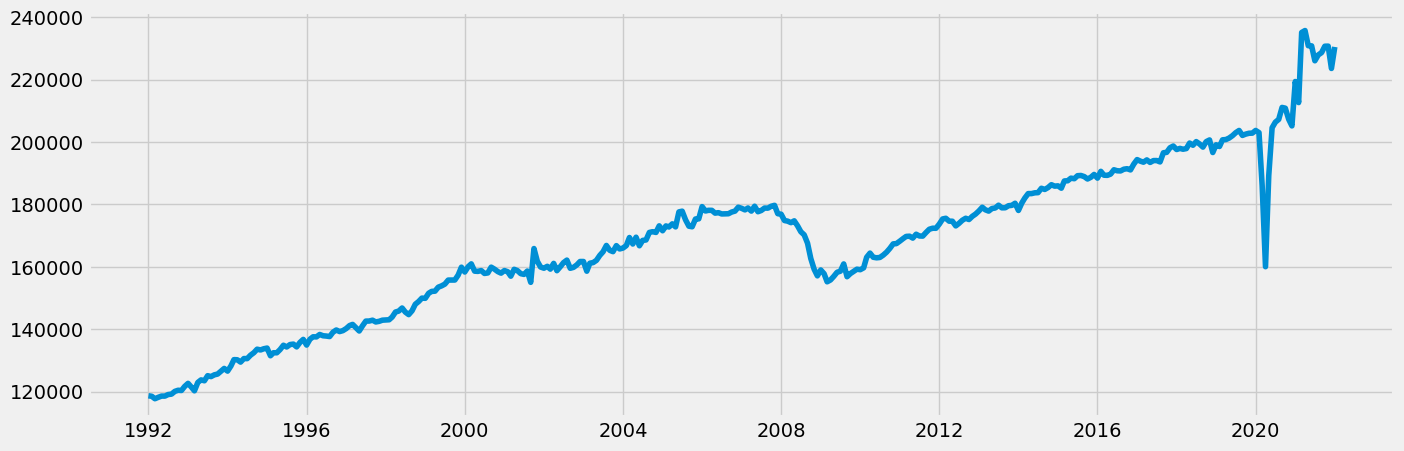

In [10]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) 

# The dpi argument controls the quality of the visualization here. When it's set to 100,
# it will produce lower-than-standard quality, which is useful if, similar to this notebook, you'll have a lot of plots.
# A large number of plots will increase the size of the notebook, which could take more time to load and eat up a lot of RAM!

plt.plot(data)

### 2. Subsetting, wrangling, and cleaning time-series data

In [11]:
# Reset index so that you can use the "Date" column as a filter

data_2 = data.reset_index()

In [12]:
data_2.head()

,Date,Value
0,1992-01-01,118651.0
1,1992-02-01,118480.0
2,1992-03-01,117700.0
3,1992-04-01,118156.0
4,1992-05-01,118548.0


In [32]:
data_sub = data_2.loc[(data_2['Date'] >= '1994-01-01') & (data_2['Date'] < '2020-12-31')]

In [33]:
data_sub.shape

(324, 2)

In [34]:
data_sub.head()

,Date,Value
24,1994-01-01,126550.0
25,1994-02-01,128203.0
26,1994-03-01,130237.0
27,1994-04-01,130190.0
28,1994-05-01,129443.0


In [35]:
# Set the "Date" column as the index

from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['Date']) # Create a datetime column from "Date.""
data_sub = data_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
data_sub.drop(['Date'], axis=1, inplace=True) # Drop the "Date" column.
data_sub.head()

,Value
datetime,
1994-01-01,126550.0
1994-02-01,128203.0
1994-03-01,130237.0
1994-04-01,130190.0
1994-05-01,129443.0


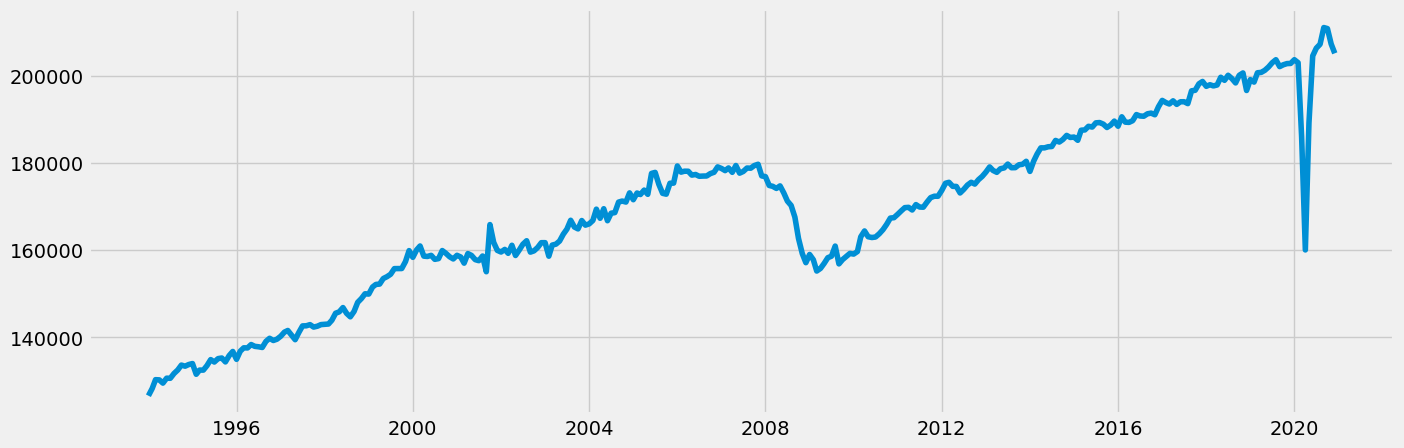

In [36]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

In [37]:
# Check for missing values (you shouldn't have any)

data_sub.isnull().sum() 

Value    0
dtype: int64

In [38]:
# Check for duplicates

dups = data_sub.duplicated()
dups.sum()

# No dups!

1

### 3. Time-series analysis: decomposition

In [39]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')

In [40]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

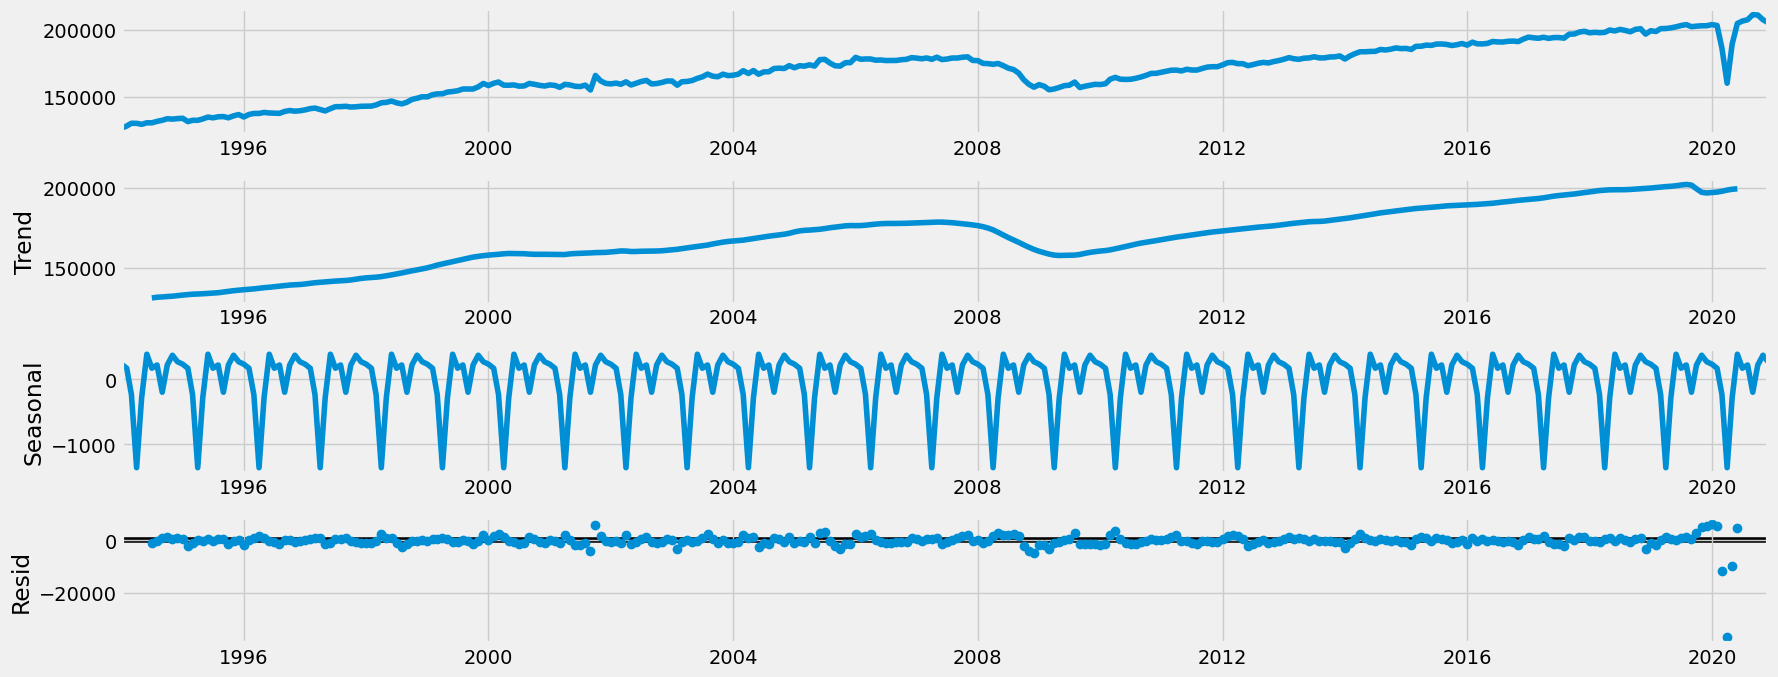

In [41]:
# Plot the separate components

decomposition.plot()
plt.show()

### 4. Testing for stationarity

In [42]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                  -0.838794
p-value                          0.807460
Number of Lags Used              5.000000
Number of Observations Used    318.000000
Critical Value (1%)             -3.451082
Critical Value (5%)             -2.870672
Critical Value (10%)            -2.571636
dtype: float64


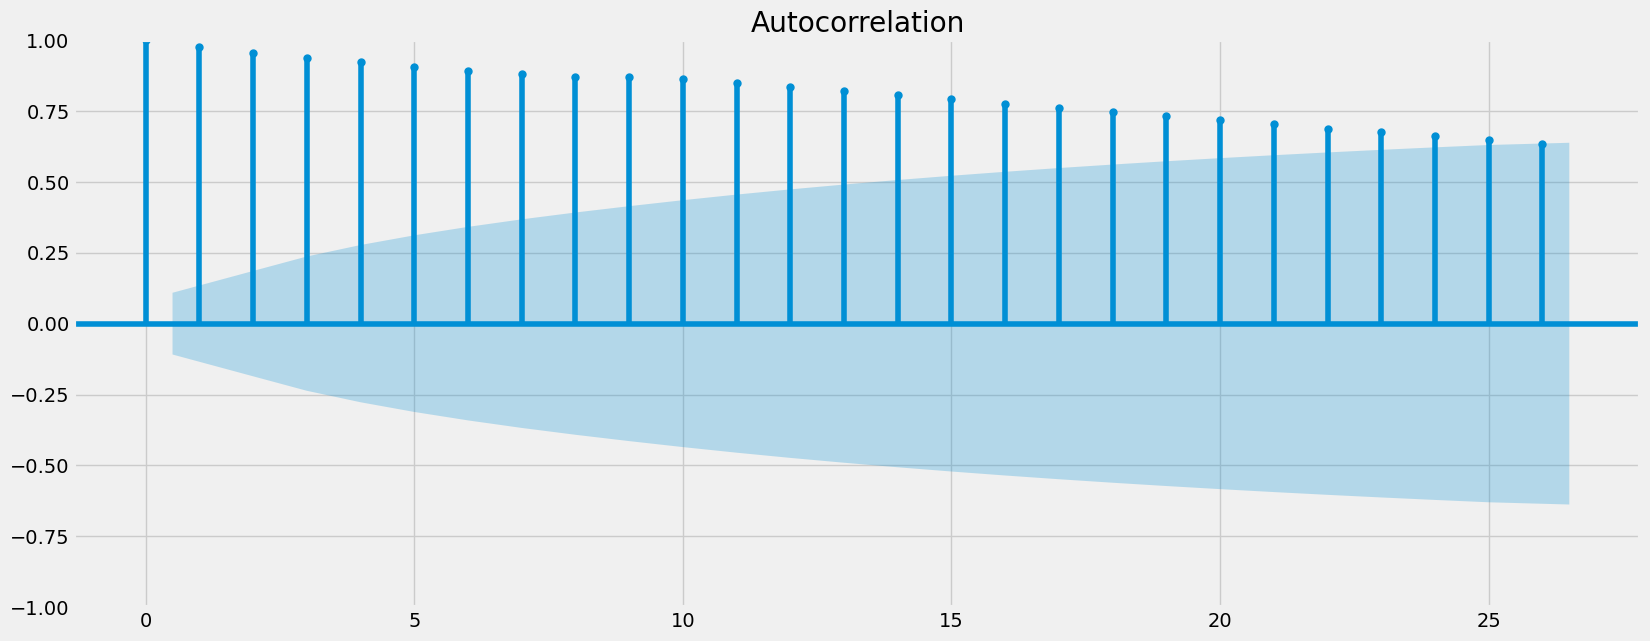

In [43]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_sub)
plt.show()

### 5. Stationarizing the Federal Reserve Economic Data

In [44]:
data_diff = data_sub - data_sub.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [45]:
data_diff.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [46]:
data_diff.head()

,Value
datetime,
1994-02-01,1653.0
1994-03-01,2034.0
1994-04-01,-47.0
1994-05-01,-747.0
1994-06-01,1138.0


In [47]:
data_diff.columns

Index(['Value'], dtype='object')

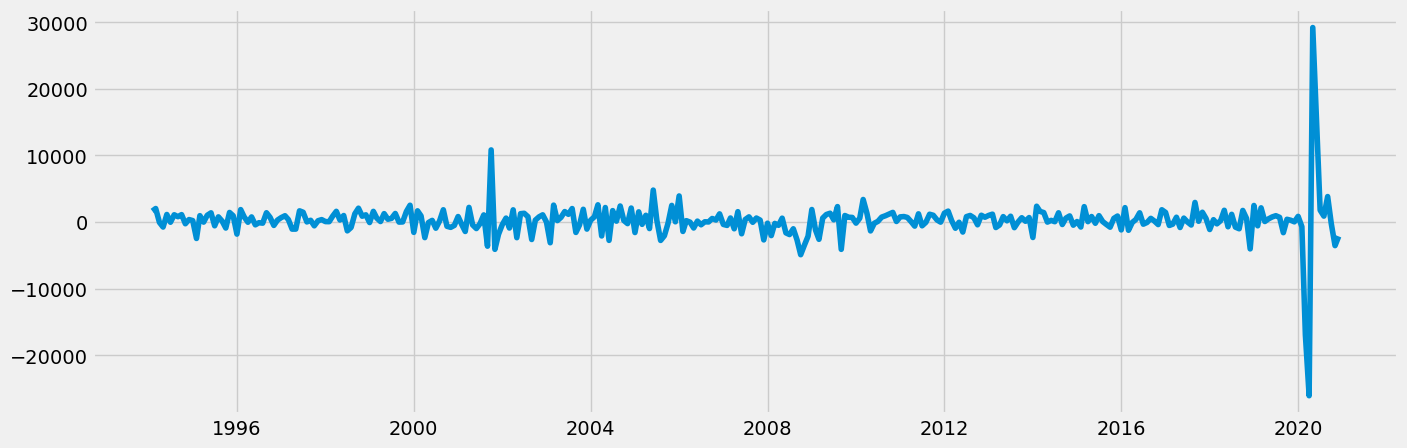

In [48]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [49]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                -1.097514e+01
p-value                        7.703537e-20
Number of Lags Used            4.000000e+00
Number of Observations Used    3.180000e+02
Critical Value (1%)           -3.451082e+00
Critical Value (5%)           -2.870672e+00
Critical Value (10%)          -2.571636e+00
dtype: float64


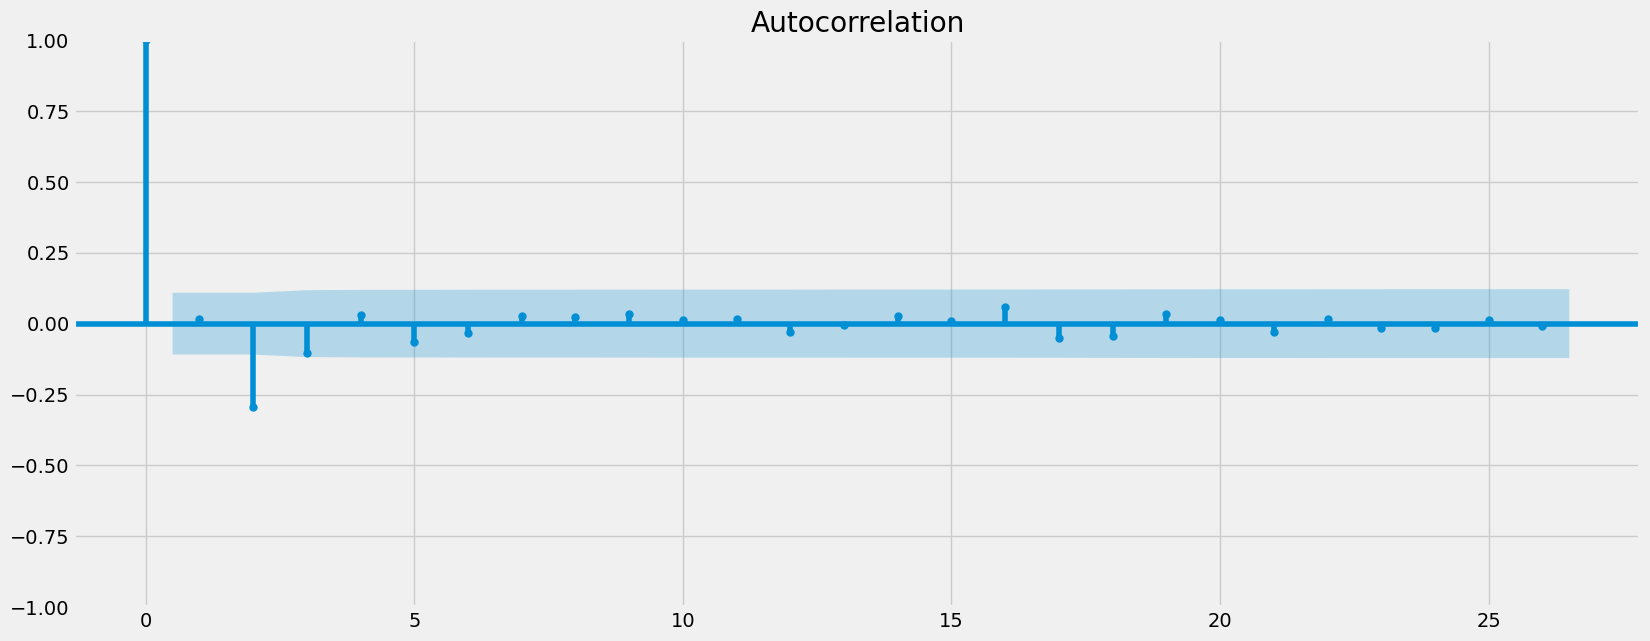

In [50]:
plot_acf(data_diff)
plt.show()